<h3> Import packages </h3>

In [2]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.tools import add_constant
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RationalQuadratic, DotProduct
import statsmodels.api as sm
import random
from matplotlib import pyplot as plt
import os
import shapely

from scipy.interpolate import interp1d

import time
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
# from collections import Counter
import pickle

%matplotlib inline
sns.set(style="ticks")

Failed `CDLL(/Library/Frameworks/GEOS.framework/Versions/Current/GEOS)`
Failed `CDLL(/opt/local/lib/libgeos_c.dylib)`


<h3> Saved constants </h3>

In [3]:
LU = pd.read_csv('boston_site_LU.csv')
LU_width = LU.shape[1]
col_names = ['Cropland', 'Golf Course',
       'Saltwater Sandy Beach', 'cemetary', 'commercial', 'crop_land',
       'forest', 'high_density_residential', 'industrial',
       'low_density_residential', 'marina', 'medium_density_residential',
       'mining', 'open_land', 'recreational', 'transitional', 'transportation',
       'urban_public/institutional', 'waste', 'water', 'wetland', 'Sample Collection Start Time']

In [4]:
W = pd.read_csv('wunderground_csvs/weather_averages.csv')
lat = W['latitude']
lon = W['longitude']
stations = list(zip(lat, lon))

In [29]:
pollutants = ['CO', 'SO', 'NO', 'OZO', 'PM']
local_path = 'Appended_AQ_Data/'

alphas = [0.0008468, 0.000000001, 0.000001, 0.00001, 0.0000008]

x_label = 'Time'
y_labels = pollutants

In [6]:
# generate grid vertices/ticks

x = [ -71.20197, -70.96679]
y = [42.291441, 42.420578]
x_cell = 50
y_cell = 50

x_min = -71.20197
x_max = -70.96679
y_min = 42.291441
y_max = 42.420578

# create ticks
x_s = np.linspace(x_min, x_max, x_cell + 1)
y_s = np.linspace(y_min, y_max, y_cell + 1)

<h3> Define functions for land use data cleaning</h3>

In [7]:
# given lat/lon spot
# return indicies for lat/lon grid box bounds
# where bounds are:
# y_s[lat_index - 1], y_s[lat_index]
# x_s[lon_index - 1], x_s[lon_index]
def find_gridbox(lat, long):
    # locate correct grid box bounds
    lat_index = 0
    lon_index = 0
    for i in range(0, 50):
        if x_s[i] < long:
            lon_index = i
        if y_s[i] > lat:
            lon_index = i
    return (lat_index, lon_index)

In [8]:
# function to parse string from "Grids" column in boston_preds.csv
# returns list of grid vertices as float64 tuples
def parse_str(str_edit):
    str_edit = str_edit.replace('[', '')
    str_edit = str_edit.replace('(', '')
    str_edit = str_edit.replace(']', '')
    str_edit = str_edit.replace(')', '')
    str_edit = str_edit.replace(',', '')
    list = str_edit.split(' ')
    return [(np.float64(list[0]), np.float64(list[1])), (np.float64(list[2]), np.float64(list[3])),
            (np.float64(list[4]), np.float64(list[5])), (np.float64(list[6]), np.float64(list[7]))]

In [9]:
# given lat, lon, and string containing cell verticies as tuples
# return boolean value of whether or not lat/lon point is in cell

def in_cell(lat, lon, cell):
    cell_points = parse_str(cell)
    lat_bool = lat > cell_points[0][0] and lat < cell_points[2][0]
    lon_bool = lon > cell_points[0][1] and lon < cell_points[2][1]
    if lat_bool and lon_bool:
        return True
    else:
        return False

In [10]:
# adds land use columns to passed in dataframe,
# returns edited version of dataframe

def add_columns(df):
    
    df['Cropland'] = 0
    df['Golf Course'] = 0
    df['Saltwater Sandy Beach'] = 0
    df['cemetary'] = 0
    df['commercial'] = 0
    df['crop_land'] = 0
    df['forest'] = 0
    df['high_density_residential'] = 0
    df['industrial'] = 0
    df['low_density_residential'] = 0
    df['marina'] = 0
    df['medium_density_residential'] = 0
    df['mining'] = 0
    df['open_land'] = 0
    df['recreational'] = 0
    df['transitional'] = 0
    df['transportation'] = 0
    df['urban_public/institutional'] = 0
    df['waste'] = 0
    df['water'] = 0
    df['wetland'] = 0
    
    return df

In [11]:
# AQ_df is the Boston AQ hourly
# LU_df contains the cells and the landuse
# AQ_index is the row of the cell that contains the point in the Boston AQ hourly df
# LU_index is the row of the cell that contains the point in the cell and landuse df

def update_proportions(AQ_df, LU_df, AQ_index, LU_index):
    
    for col in range(0, LU_width - 2):#df.loc[i, 'forest'] = df.loc[i, 'forest'] + my_dict['forest']
        # print (AQ_index, AQ_width + col, LU_index, col + 1), "\n"
        # print AQ_df.iloc[AQ_index, col + AQ_width], "LU:", LU_df.iloc[LU_index, col+2]
        AQ_df.iloc[AQ_index, col + AQ_width] = LU_df.iloc[LU_index, col + 2]
    
    return AQ_df

In [12]:
#AQ_df is the Boston AQ hourly
#LU_df contains the cells and the landuse
#AQ_index is the row of the cell that contains the point in the Boston AQ hourly df
#LU_index is the row of the cell that contains the point in the cell and landuse df

def fill_in_weather(aq_df, weather_df, aq_index, weather_index):
    
    aq_df.iloc[aq_index, "Weather"] = weather_df.iloc[weather_index, "weather"]
    
    return aq_df

In [13]:
# return numerical distance between two lat lon points
def get_distance(aq_lat, aq_lon, weather_lat, weather_lon):
    dist = math.sqrt((aq_lat - weather_lat)**2 + (aq_lon - weather_lon)**2)
    return dist

# given lat lon point, return index of row in weather_averages.csv file
# that represents the closest sensor
def find_sensor(aq_lat, aq_lon):
    distances = []
    for index in range(len(stations)):
        distances[index] = get_distance(aq_lat, aq_lon, stations[i][0], stations[i][1])
    return distances.index(min(distances))

<h3> Define functions needed for Gaussian process </h3>

In [52]:
"""Splits dataframe into train and test data"""
def split_train_test(df):
    train, test = train_test_split(df, test_size=.30, random_state=0)
    x_train = train["Sample Collection Start Time"]
    y_train = train["Measure Value"]
    x_test = test["Sample Collection Start Time"]
    y_test = test["Measure Value"]
    return x_train, y_train, x_test, y_test

"""
Creates Gaussian model, computs r squarred, MSE and log liklihood
Given x_train, y_train, x_test, and y_test data, and numerical alpha value
Prints train and test R^2

"""

def simple_gaussian(x_train, y_train, x_test, y_test, alpha):
    
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    kern = RBF(length_scale = 1)
    
    gp = GaussianProcessRegressor(kernel=kern, alpha=alpha, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=False, copy_X_train=False, random_state=None)
    gp.fit(x_train.reshape(train_size, 1), y_train.reshape(train_size, 1))

    y_train_pred, sigma_train = gp.predict(x_train.reshape(train_size, 1), return_std=True)
    y_test_pred, sigma_test = gp.predict(x_test.reshape(test_size, 1), return_std=True)

    # get R^2
    r2 = gp.score(x_train.reshape(train_size, 1), y_train.reshape(train_size, 1))
    r2_t = gp.score(x_test.reshape(test_size, 1), y_test.reshape(test_size, 1))

    # get MSE measurements
    MSE_test = np.mean((y_test_pred - y_test.reshape(test_size, 1))**2)
    MSE_train = np.mean((y_train_pred - y_train.reshape(train_size, 1))**2)

    # get log likelihood
    t = gp.log_marginal_likelihood()

    # calculate AIC
    AIC = 2*len(x_test) - 2*np.log(-t)
    
    # print R^2 values
    print('mean squared error of train data with model = ' + str(MSE_train))
    print('mean squared error of test data with model = ' + str(MSE_test))
    print('Akaike information criterion = ' + str(AIC))
    print('log likelihood of model = ' + str(t))
    print('training R^2 value = ' + str(r2))
    print('testing R^2 value = ' + str(r2_t))
    
    return y_train_pred, y_test_pred, gp

"""Plots predicted y values for testing set"""
def plot_predictions(x_test, y_test, y_test_pred, x_label, y_label):
    plt.figure(figsize=(20,8))
    data = plt.plot(x_test, y_test, '.', color="b",)
    model = plt.plot(x_test, y_test_pred, 'ro')
    # f = interp1d(np.sort(x_test), y_test, kind=1)
    # plt.plot(x_test, f(x_test))
    plt.legend(['data', 'model'], frameon=True)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()

<h3> Code to combine AQ data file with land use data and implement Gaussian process</h3>

In [ ]:
# note: this cell takes a long time
# for each pollutant, prepare a cleaned dataframe with land use
# dataframes list ends up with order: 'CO', 'SO', 'NO', 'OZO', 'PM'

sites = LU['Site']
dataframes = np.zeros(5, dtype=pd.DataFrame)

for i in range(0,1):

    filename = local_path + 'appended' + pollutants[i] + '.csv'
    
    AQ = pd.read_csv(filename)
    
    lat = AQ['Latitude']
    lon = AQ['Longitude']
    AQ['lat_lon'] = list(zip(lat, lon))
    pts = AQ['lat_lon']
    
    AQ_width = AQ.shape[1]

    AQ = add_columns(AQ)

    for pt in range(len(AQ['lat_lon'])):
        for cell in range(len(sites)):
            if in_cell(pts[pt][1], pts[pt][0], LU['Site'][cell]):
                # add cell info to appendedAQ.csv file
                AQ = update_proportions(AQ, LU, pt, cell)
    
    dataframes[i] = AQ

In [16]:
# note: this cell takes a long time
# for each pollutant, prepare a cleaned dataframe with land use
# dataframes list ends up with order: 'CO', 'SO', 'NO', 'OZO', 'PM'

sites = LU['Site']
dataframes = np.zeros(5, dtype=pd.DataFrame)

for i in range(0,5):

    filename = local_path + 'appended' + pollutants[i] + '.csv'
    
    AQ = pd.read_csv(filename)
    
    lat = AQ['Latitude']
    lon = AQ['Longitude']
    AQ['lat_lon'] = list(zip(lat, lon))
    pts = AQ['lat_lon']
    
    dataframes[i] = AQ

/Users/Annamira/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:25: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/Annamira/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:27: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/Annamira/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/Annamira/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/Annamira/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/Annamira/anac

mean squared error of train data with model = 0.00170781088062
mean squared error of test data with model = 0.00186448623062
Akaike information criterion = nan
log likelihood of model = 409.428067626
training R^2 value = 0.65717501531
testing R^2 value = 0.494227868694


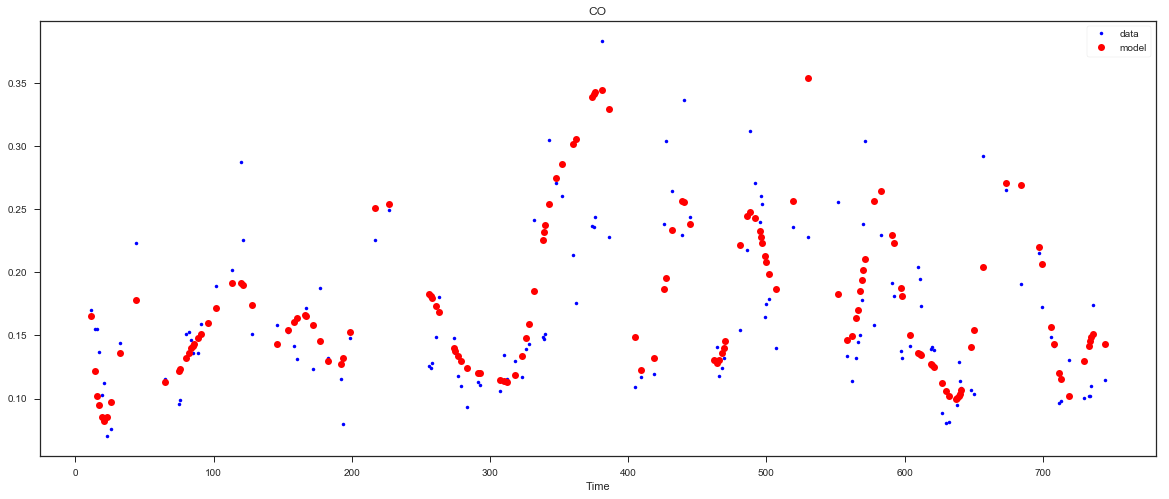

/Users/Annamira/anaconda/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


mean squared error of train data with model = 2.29989225676e-09
mean squared error of test data with model = 3.01358604559e-09
Akaike information criterion = nan
log likelihood of model = 1932.92871906
training R^2 value = 0.930270033997
testing R^2 value = 0.914734377771


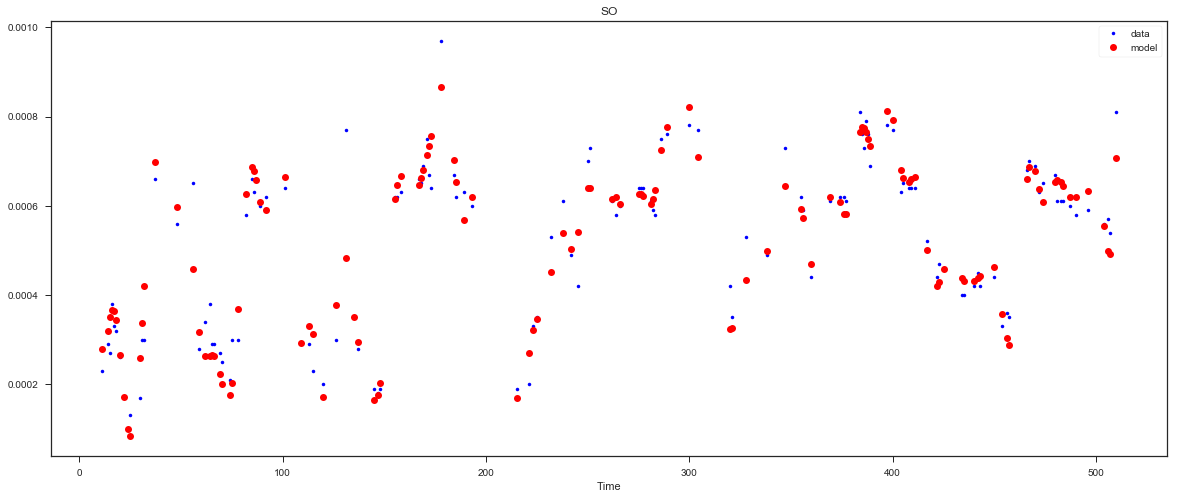

mean squared error of train data with model = 1.58133382703e-06
mean squared error of test data with model = 6.22978508112e-06
Akaike information criterion = nan
log likelihood of model = 2252.5679048
training R^2 value = 0.9502069239
testing R^2 value = 0.797110335034


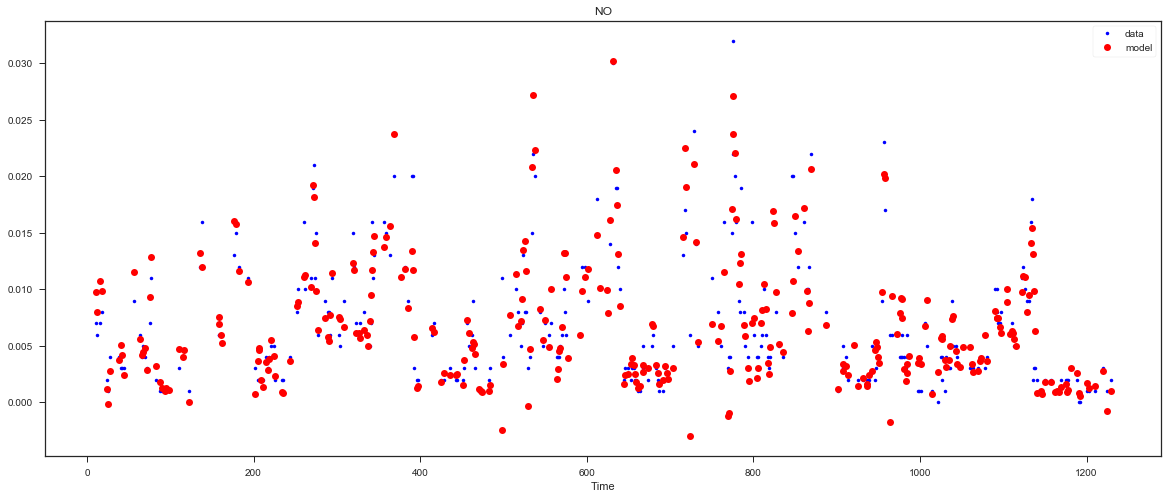

mean squared error of train data with model = 9.16872066165e-06
mean squared error of test data with model = 1.81103533186e-05
Akaike information criterion = nan
log likelihood of model = 1358.23807123
training R^2 value = 0.933606560184
testing R^2 value = 0.877262936467


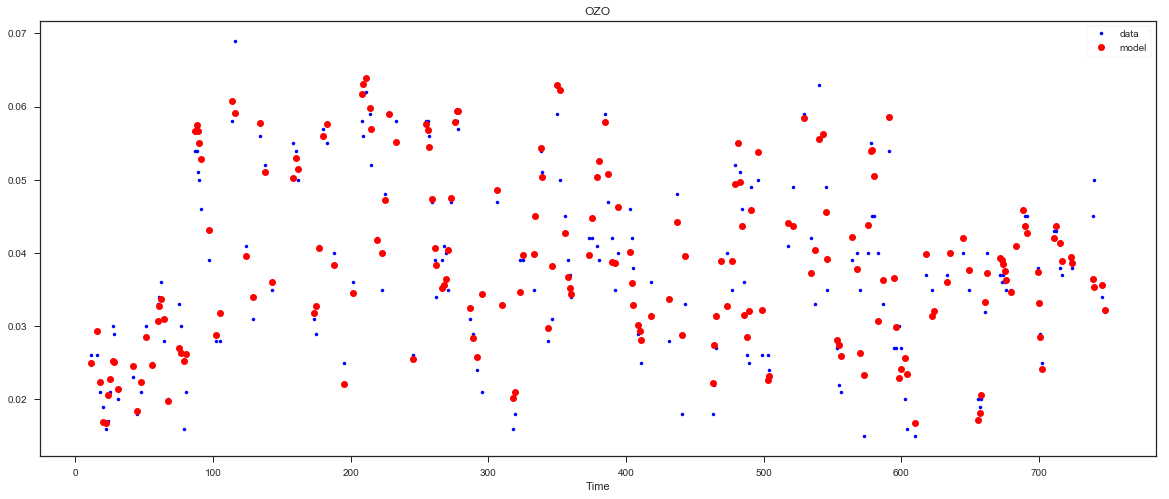

mean squared error of train data with model = 0.0666666667236
mean squared error of test data with model = 27.3504815394
Akaike information criterion = 288.869713526
log likelihood of model = -15636887.0743
training R^2 value = 0.997561334706
testing R^2 value = 0.0361871310906


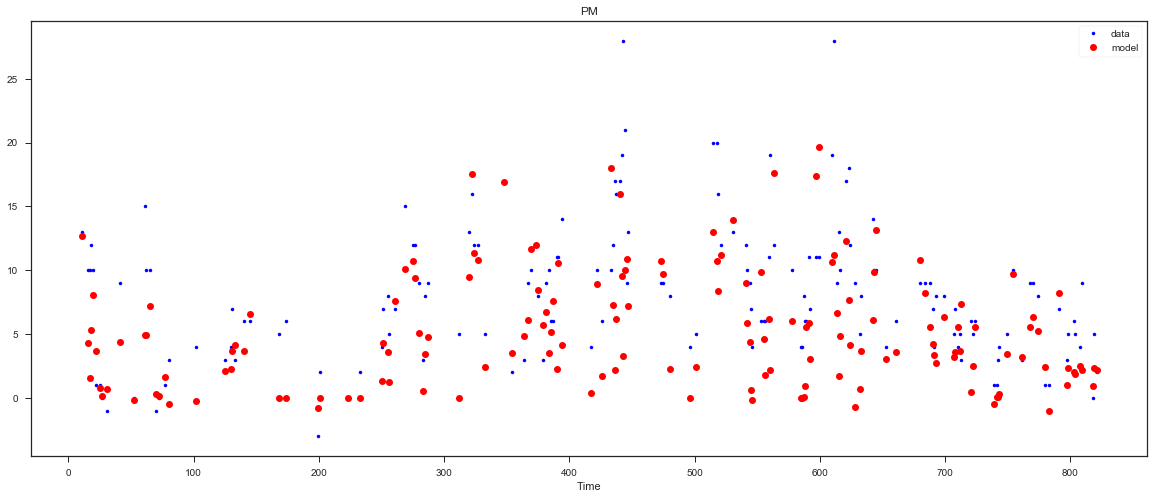

In [53]:
# for each pollutant, do a gaussian process

for i in range(0,5):
    
    AQ = dataframes[i]
    
    x_train, y_train, x_test, y_test = split_train_test(AQ)

    y_train_pred, y_test_pred, gp = simple_gaussian(x_train, y_train, x_test, y_test, alphas[i])

    plot_predictions(x_test, y_test, y_test_pred, x_label, y_labels[i])

In [45]:
plt.legend?